In [1]:
import icon_registration.networks as networks
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from icon_registration.mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import icon_registration.inverseConsistentNet as inverseConsistentNet
import icon_registration.network_wrappers as network_wrappers
import icon_registration.data as data
import numpy as np
import matplotlib.pyplot as plt
import itk

/playpen-raid1/tgreer/ICON/src/icon_registration/inverseConsistentNet.py:3: UserWarning: inverseConsistentNet.py is deprecated, its code has been moved to losses.py
        In a future release this file may be deleted.
  warnings.warn(


In [3]:
r_ds = torch.load("/playpen/tgreer/knees_test_set_hires")
#batched_ds = list(zip(*[r_ds[i::4] for i in range(2)]))


In [4]:
batched_ds = list(zip(*[r_ds[i::2] for i in range(2)]))

In [5]:

phi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3))

pretrained_lowres_net = network_wrappers.DoubleNet(phi, psi)

regis_net = network_wrappers.DoubleNet(
    network_wrappers.DownsampleNet(pretrained_lowres_net, 3), 
    network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3)))

regis_net = network_wrappers.DoubleNet(
    regis_net, 
    network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3)))

BATCH_SIZE = 8
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]
    
regis_net.assign_identity_map(input_shape)
net = inverseConsistentNet.InverseConsistentNet(
    regis_net, 
    lambda x, y: torch.mean((x - y) **2),
    3600,
)
trained_weights = torch.load("/playpen-raid1/tgreer/ICON/training_scripts/gradICON/results/gradkneedoublehalfres-4/knee_aligner_resi_net22500")
regis_net.load_state_dict(trained_weights, strict=False
                         )


<All keys matched successfully>

In [6]:
!ntop

Wed Sep 21 11:12:14 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 31%   30C    P2    52W / 250W |   1294MiB / 11019MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:5E:00.0 Off |                  N/A |
| 31%   26C    

In [7]:

BATCH_SIZE = 2
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net.assign_identity_map(input_shape)

In [8]:
import icon_registration

In [9]:

net.cuda()
net.eval()
0

0

In [20]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0)# / BATCH_SIZE
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    mag = []
    
    
    for x in batched_ds[:]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]

        l = icon_registration.losses.to_floats(net(moving_image, fixed_image))
        mag.append(l.transform_magnitude)
        phi_AB_vectorfield = net.phi_AB(net.identity_map)
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 0)
        wmb = torch.round(warped_moving_cartilage) == 1
        fb = torch.round(fixed_cartilage) == 1
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        dV = flips2(phi_AB_vectorfield)
        
        dV = np.array(dV).flatten()
        dV = dV[dV < 0]
        filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)
    
    print("mag", sum(mag) / len(mag))

tensor([0.6772, 0.7559], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7480, 0.6725], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6870, 0.6735], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7668, 0.7090], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6938, 0.7655], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7152, 0.7798], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7513, 0.5915], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6515, 0.7714], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6920, 0.7408], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6247, 0.7288], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7132, 0.7421], device='cuda:0'

tensor([0.7103, 0.7640], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6698, 0.7259], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7304, 0.7625], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7319, 0.7398], device='cuda:0')
tensor(9, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7325, 0.7312], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6994, 0.7231], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6695, 0.7390], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6460, 0.7370], device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7304, 0.5902], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7062, 0.7444], device='cuda:0')
tensor(109, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7707, 0.6977], device='cuda:

0.7130368
0.76


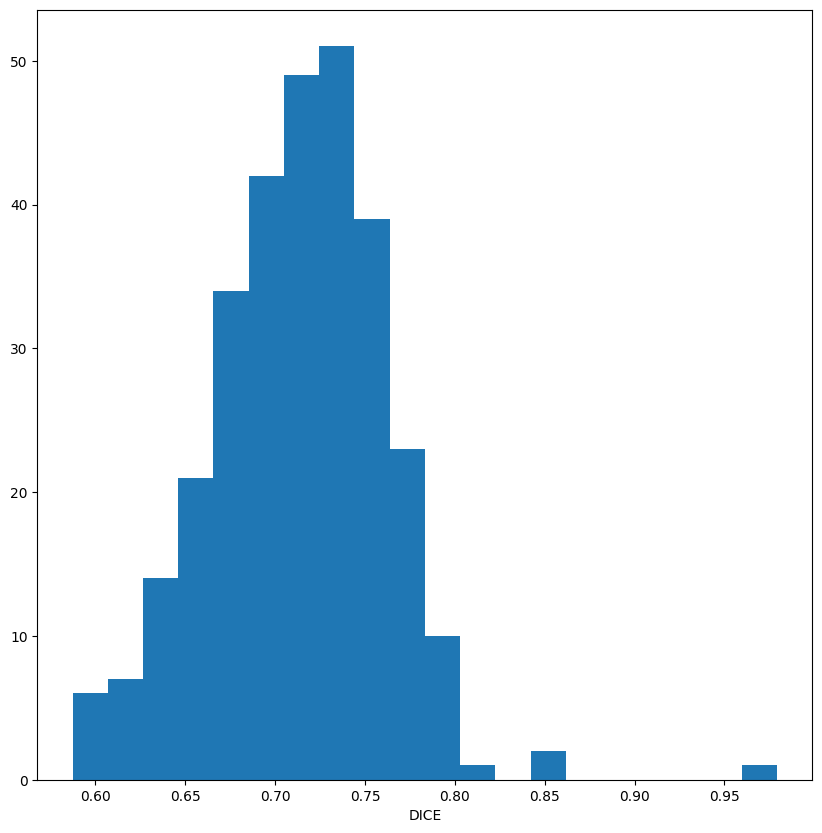

In [21]:
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)

In [12]:
net.cuda()
with torch.no_grad():
    print(net(moving_image, fixed_image))

ICONLoss(all_loss=tensor(0.7622, device='cuda:0'), inverse_consistency_loss=tensor(5.5582e-05, device='cuda:0'), similarity_loss=tensor(0.5621, device='cuda:0'), transform_magnitude=tensor(0.0041, device='cuda:0'), flips=tensor(0., device='cuda:0'))


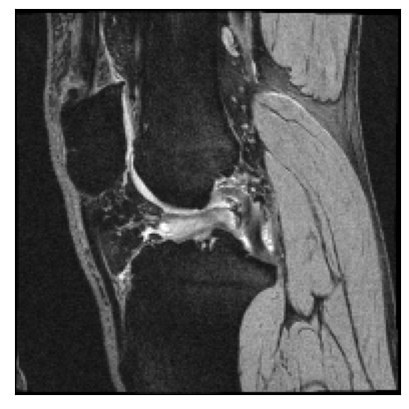

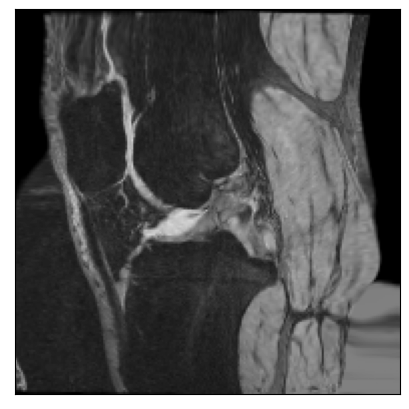

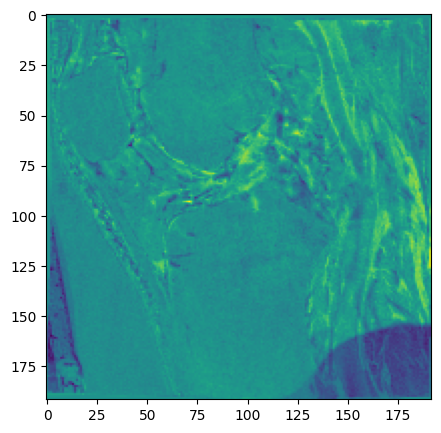

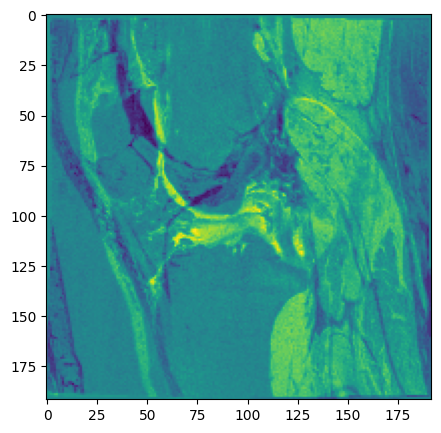

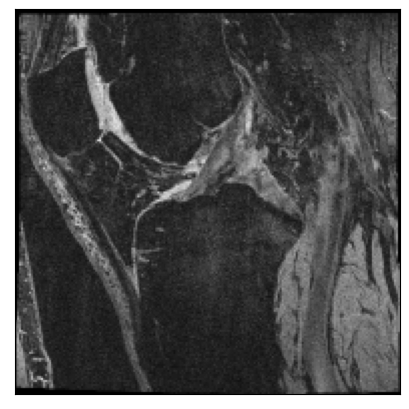

In [13]:



if not("N" in locals()):
    N = 0
N += 1
N %= 2
#N = 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 40
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach() - moving_image[N, 0, slice_ ].cpu().detach())
plt.show()
#plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
#plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

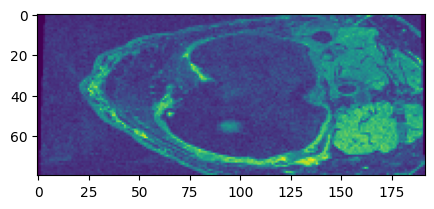

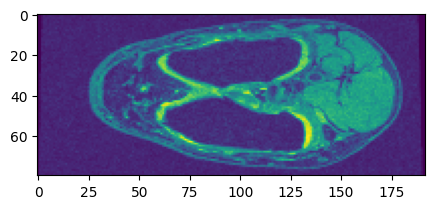

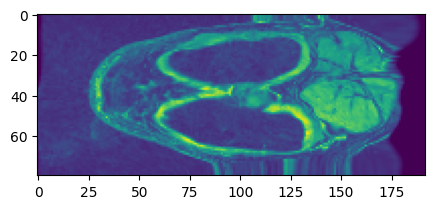

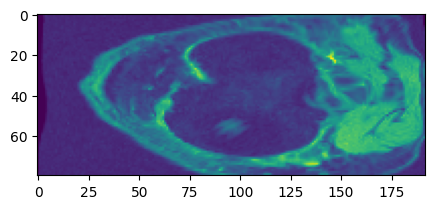

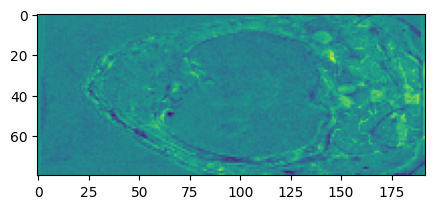

In [14]:
import matplotlib.pyplot as plt
S = 100
plt.imshow(moving_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(fixed_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(net.warped_image_A[N, 0, :, S].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach() - moving_image[N, 0, :, S].cpu())

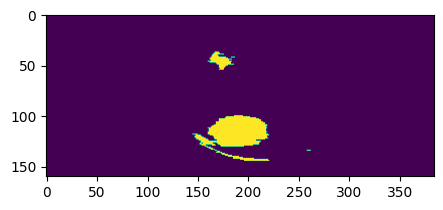

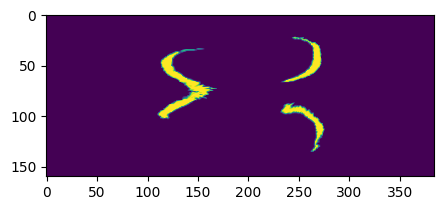

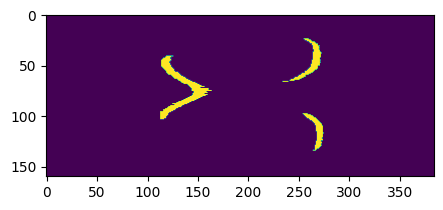

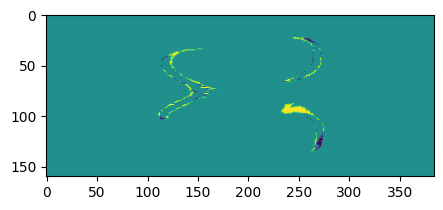

In [15]:

S = 49
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()


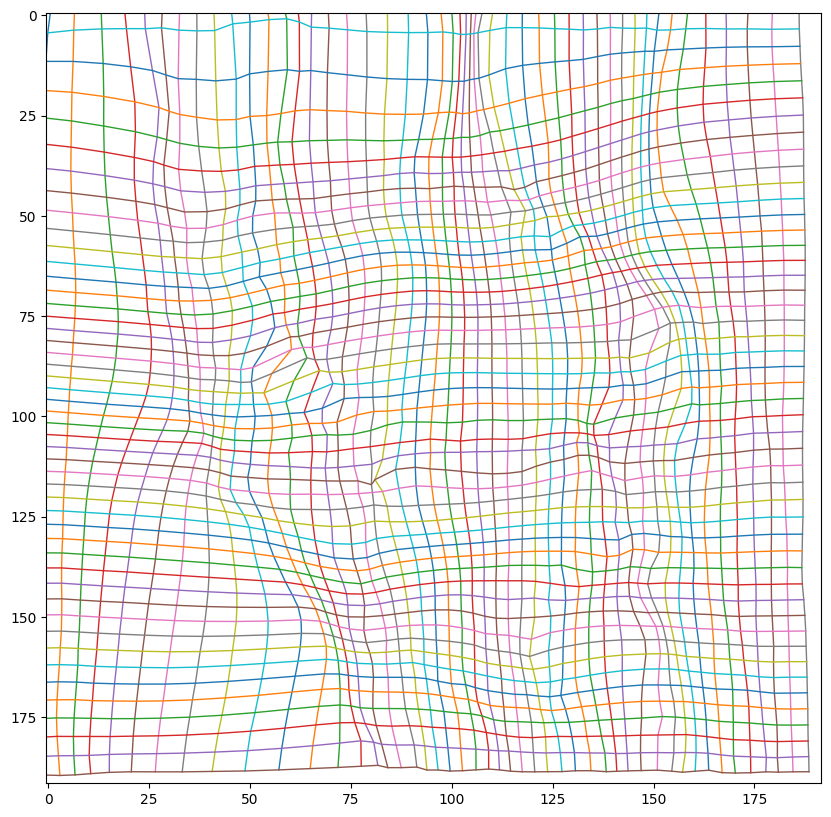

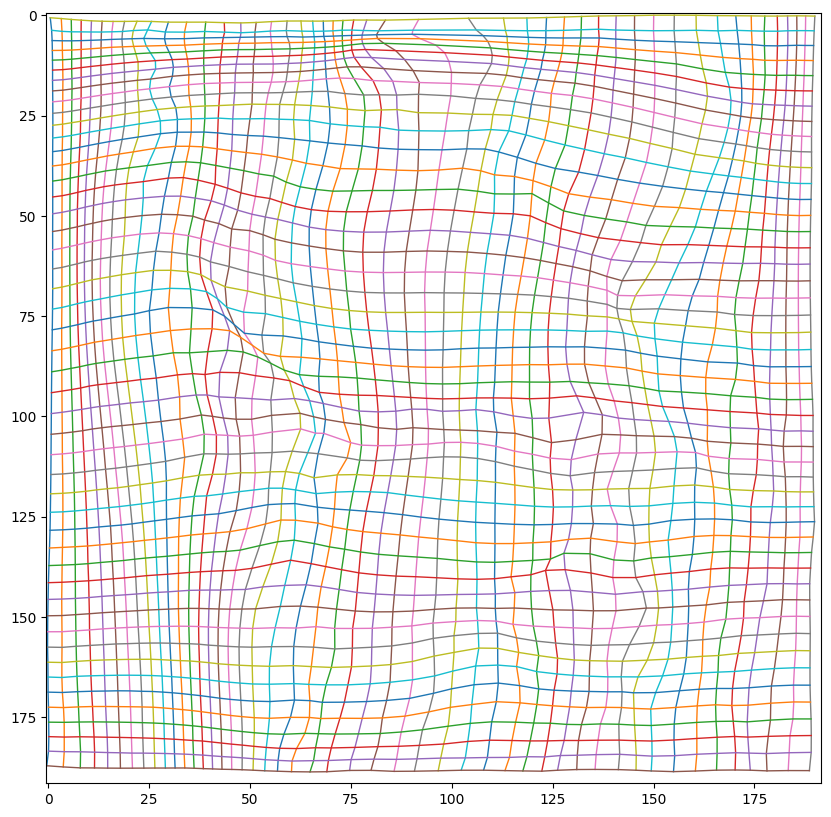

In [16]:
import icon_registration.visualize as visualize
N = (N + 1)% 2
#N = 1
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
plt.show()
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])


In [17]:
net.phi_AB.__closure__[0].cell_contents

<function icon_registration.network_wrappers.TwoStepRegistration.forward.<locals>.<lambda>(input_)>

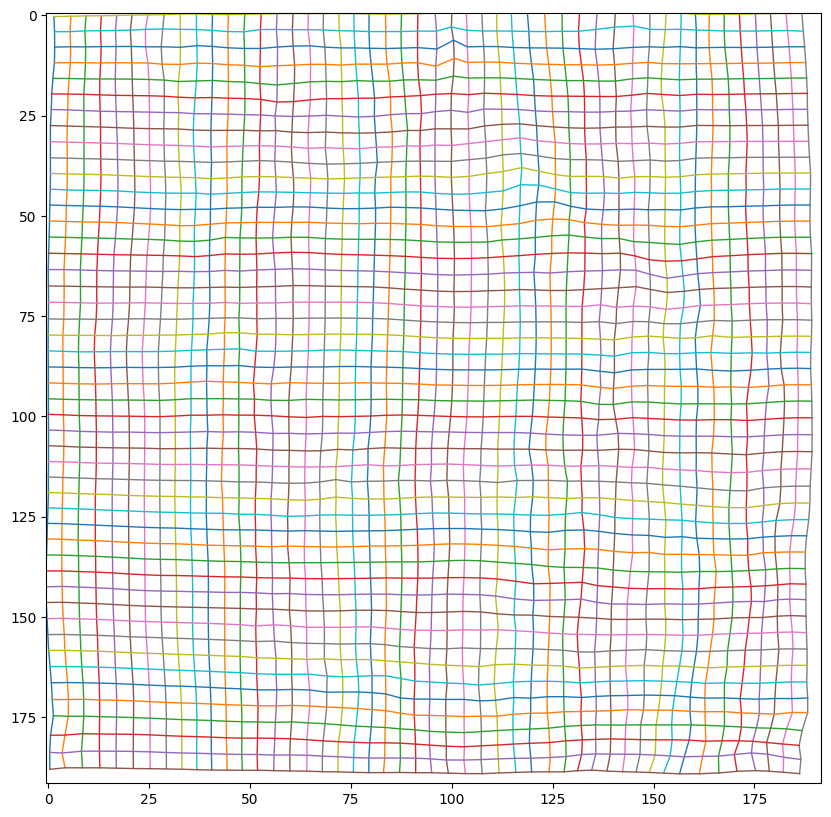

In [18]:
N = (N + 1) % 2
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identity_map))[N, [1, 2], 20])

In [19]:
import visualize
mp = pretrained_lowres_net.phi_AB(hires_Net.identityMap[:, :, ::2, ::2, ::2])
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleNotFoundError: No module named 'visualize'

In [ ]:
import visualize
mp = hires_Net.phi_BA(hires_Net.regis_net.net.identityMap)
visualize.show_as_grid(mp[N, [1, 2], 20])

In [ ]:
mkdir supll_regis_figures


In [ ]:
import importlib
importlib.reload(visualize)
import matplotlib.colors as colors

for N in range(2):

    plt.rcParams["figure.figsize"] = (5, 5)
    def imshow(x):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
    offset = 0
    slice_ = 20
    
    for axis in ["Coronal", "Sagittal", "Axial"]:
        m_image = moving_image[N, 0].cpu().detach()
        f_image = fixed_image[N, 0].cpu().detach()
        m_warped_image_A = net.warped_image_A[N, 0].cpu().detach() 
        phi_BA = net.phi_BA_vectorfield[N]
        
        dV = flips2(net.phi_AB_vectorfield)[N, 0]
        
        if axis == "Sagittal":
            m_image_slice = m_image[slice_]
            f_image_slice = f_image[slice_]
            warped_image_A_slice = m_warped_image_A[slice_]
            phi_BA_slice = phi_BA[[1, 2], 20].clone()
            dV_slice = dV[slice_]
        if axis == "Coronal":
            m_image_slice = m_image[:, slice_].transpose(0, 1)
            f_image_slice = f_image[:, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[2, 0], :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, slice_].transpose(0, 1)
        if axis == "Axial":
            slice_ *= 2
            m_image_slice = m_image[:, :, slice_].transpose(0, 1)
            f_image_slice = f_image[:, :, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, :, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[1, 0], :, :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, :, slice_].transpose(0, 1)
            slice_ /= 2
            
            
        
        header = f"supll_regis_figures/{axis}Pair{N + offset}"
        imshow(m_image_slice)
        plt.savefig(header + "ImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(f_image_slice)
        plt.savefig(header + "ImageB.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        plt.savefig(header + "WarpedImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        visualize.show_as_grid(phi_BA_slice)
        plt.savefig(header + "WarpedImageAGrid.png", bbox_inches="tight")
        plt.clf()
        
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(dV_slice, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
        plt.title("min dV is $\\bf{" + f"{np.min(dV_slice.numpy()):.3}" + "}$ in this slice", 
                 fontdict={'fontsize':13})
        plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
        #lt.show()
        #plt.imshow(dV[1, 0, 40] < 0)


        plt.savefig(header + "dV.png", bbox_inches="tight")
        plt.clf()
    """
    imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach())
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageB.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageBGrid.png")
    plt.clf()
    """

    
    plt.show()

In [ ]:
import importlib
importlib.reload(visualize)

In [ ]:
plt.imshow(torch.min(dV[1, 0], axis=0).values)
plt.colorbar()

In [ ]:
torch.sum(dV[1] < 0)

In [ ]:
dV

In [ ]:
116 / (80 * 192 * 192), 1 / 25000

In [ ]:
import matplotlib.colors as colors

plt.xticks([])
plt.yticks([])
query = dV[0, 0, 43]
plt.imshow(query, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
plt.title("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice", 
         fontdict={'fontsize':13})
plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
#lt.show()
#plt.imshow(dV[1, 0, 40] < 0)


plt.savefig("dVslice0.pdf", bbox_inches="tight")


In [ ]:
2 * np.sum(folds_list) / (np.product(list(dV.shape)) * len(r_ds))

In [ ]:
print("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice")
from matplotlib import rc
rc('text', usetex=False)
np.min(query.numpy())

In [ ]:
adv = np.array(dV)
filteredDV = adv[adv < 0.05]
plt.hist(filteredDV, bins=100)
plt.show()

In [ ]:
plt.hist(np.concatenate(filteredDV_list), bins=100)
plt.title("Distribution of negative dV voxels in test set")
plt.xlabel("dV (in voxels³)")
plt.ylabel("Count")
plt.savefig("DistributionNegativeJacobian.pdf")

In [ ]:
np.mean(np.concatenate(filteredDV_list))

In [ ]:
np.median(np.concatenate(filteredDV_list))

In [ ]:
np.percentile(np.concatenate(filteredDV_list), 1)

In [ ]:
%time net.regis_net(moving_image, fixed_image)

In [ ]:

with torch.no_grad():
    x = batched_ds[0]
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    

In [ ]:
%%time
with torch.no_grad():
    phi = net.regis_net(moving_image, fixed_image)
    phi_AB_vectorfield = phi(net.identityMap).cpu()

In [ ]:
%%time 
net(moving_image, fixed_image)

In [ ]:
plt.hist(torch.cat(dices).cpu().detach().numpy(), bins=30)

In [ ]:
pixel_displacement = ((net.phi_AB_vectorfield.cpu() - net.identityMap.cpu()) 
    * torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None])
plt.imshow(pixel_displacement[0, 2, 40], cmap="rainbow")
plt.colorbar()

In [ ]:
torch.max(torch.abs(pixel_displacement))

In [ ]:
error = (net.phi_AB(net.phi_BA_vectorfield) - net.identityMap).cpu()* torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None]

In [ ]:
plt.imshow((error)[0, 0, 40])
plt.colorbar()

In [ ]:
torch.sqrt(torch.mean(error**2))

In [ ]:
plt.rcParams["figure.figsize"]

In [ ]:
plt.hist(folds_list, bins=40)
plt.xlabel("number of folded pixels")
plt.ylabel("number of image pairs")

In [ ]:


import pickle
with open("../results/grad_hires-1/loss_curve", "rb") as f:
    ncurve2 = pickle.load(f)
ncurve2 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in ncurve2]
ncurve2 = np.array(ncurve2)
plt.plot(ncurve2)


import pickle
with open("../../masked_similarity_InvCon/results/hires_smart_6/loss_curve", "rb") as f:
    curve = pickle.load(f)
curve = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve]
curve = np.array(curve)
plt.plot(curve)


import pickle
with open("../../masked_similarity_InvCon/results/fourth_net_frozen/loss_curve", "rb") as f:
    curve4 = pickle.load(f)
curve4 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve4]
curve4 = np.array(curve4)
plt.plot(curve4)

In [ ]:


plt.plot(ncurve2[:, 2])

plt.plot(curve[:, 2])

plt.plot(curve4[:, 2])



In [ ]:


plt.plot(ncurve2[:, 1])


plt.plot(curve[:, 1])

plt.plot(curve4[:, 1])



In [ ]:


plt.plot(ncurve2[:, 3])


plt.plot(curve[:, 3])